# **Import Libraries**

---



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import random
from scipy.interpolate import interp1d

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [ ]:
!gdown --id '1OOft6zOd2t2A1NWTYkpq-6MyC5ySswl2'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1OOft6zOd2t2A1NWTYkpq-6MyC5ySswl2
To: /content/UCIHAR.zip
100% 24.3M/24.3M [00:00<00:00, 249MB/s]


In [ ]:
!unzip '/content/UCIHAR.zip'
!rm '/content/UCIHAR.zip'
dataset_name = "UCIHAR" 
data_class_names = ["Walking", "Stairs-Up", "Stairs-Down", "Sitting", "Standing", "Lying"]
dataset_address = "/content/UCIHAR/"
X_train = np.load(dataset_address + "X_train.npy")[:,:,:9]
Y_train = np.load(dataset_address + "y_train.npy").argmax(1)
X_test = np.load(dataset_address + "X_test.npy")[:,:,:9]
Y_test = np.load(dataset_address + "y_test.npy").argmax(1)

rnd_seed = 0
tf.random.set_seed(rnd_seed)
indices = np.random.RandomState(seed=rnd_seed).permutation(len(X_train))
X_train = X_train[indices]
Y_train = Y_train[indices]
data_class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=range(len(data_class_names)),y=Y_train)
data_class_weights = dict(zip(range(len(data_class_weights)),data_class_weights.round(2)))

Archive:  /content/UCIHAR.zip
   creating: UCIHAR/
  inflating: UCIHAR/X_test.npy       
  inflating: UCIHAR/X_train.npy      
  inflating: UCIHAR/y_test.npy       
  inflating: UCIHAR/y_train.npy      


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []

    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

In [ ]:
def ConvLSTMCombined(inp_shape, out_shape): 
    nb_filters = 64 
    drp_out_dns = .5 
    nb_dense = 128 
    
    inp = Input(inp_shape)

    x = Conv2D(nb_filters, kernel_size = (5,1),
              strides=(1,1), padding='valid', activation='relu')(inp)    
    x = Conv2D(nb_filters, kernel_size = (5,1),
              strides=(1,1), padding='valid', activation='relu')(x)
    x = Conv2D(nb_filters, kernel_size = (5,1), 
              strides=(1,1), padding='valid', activation='relu')(x)
    x = Conv2D(nb_filters, kernel_size = (5,1), 
              strides=(1,1), padding='valid', activation='relu')(x)    
    x = Reshape((x.shape[1],x.shape[2]*x.shape[3]))(x)
    act = LSTM(nb_dense, return_sequences=True, activation='tanh', name="lstm_1")(x)        
    act = Dropout(drp_out_dns, name= "dot_1")(act)
    act = LSTM(nb_dense, return_sequences=True, activation='tanh', name="lstm_2")(act)        
    act = Dropout(drp_out_dns, name= "dot_2")(act)
    act = LSTM(nb_dense, activation='tanh', name="lstm_3")(act)        
    act = Dropout(drp_out_dns, name= "dot_3")(act)
    out_act = Dense(out_shape, activation='softmax',  name="act_smx")(act)
    
    model = keras.models.Model(inputs=inp, outputs=out_act)
    model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
    return model

In [ ]:
def resampling_fast_random(x):
    M, N = random.choice([[1, 0], [2, 1], [3, 2]])
    time_steps = x.shape[1]
    raw_set = np.arange(x.shape[1])
    interp_steps = np.arange(0, raw_set[-1] + 1e-1, 1 / (M + 1))
    x_interp = interp1d(raw_set, x, axis=1)
    x_up = x_interp(interp_steps)

    length_inserted = x_up.shape[1]
    start = random.randint(0, length_inserted - time_steps * (N + 1))
    index_selected = np.arange(start, start + time_steps * (N + 1), N + 1)
    return x_up[:, index_selected, :]

def resampling(x,M,N):
    '''
    :param x: the data of a batch,shape=(batch_size,timesteps,features)
    :param M: the number of  new value under tow values
    :param N: the interval of resampling
    :return: x after resampling，shape=(batch_size,timesteps,features)
    '''
    assert M>N,'the value of M have to greater than N'

    timesetps = x.shape[1]

    for i in range(timesetps-1):
        x1 = x[:,i*(M+1),:]
        x2 = x[:,i*(M+1)+1,:]
        for j in range(M):
            v = np.add(x1,np.subtract(x2,x1)*(j+1)/(M+1))
            x = np.insert(x,i*(M+1)+j+1,v,axis=1)

    length_inserted = x.shape[1]
    start = random.randint(0,length_inserted-timesetps*(N+1))
    index_selected = np.arange(start,start+timesetps*(N+1),N+1)
    return x[:,index_selected,:]
    return x

def noise(x):
    x = tf.add(x,tf.multiply(x,tf.cast(tf.random.uniform(shape = (x.shape[0],x.shape[1],x.shape[2]),minval=-0.1,maxval=0.1),tf.float64)))
    return x


def scaling(x):
    alpha = np.random.randint(7,10)/10
    # alpha = 0.9
    return tf.multiply(x,alpha)
#
def magnify(x):
    lam = np.random.randint(11,14)/10
    return tf.multiply(x,lam)


def inverting(x):
    return np.multiply(x,-1)
def reversing(x):
    return x[:,-1::-1,:]


def rotation(x):
    c = x.shape[2]//3
    x_new = rotation_transform_vectorized(x[:,:,0:3])
    for i in range(1,c):
        temp = rotation_transform_vectorized(x[:,:,i*3:(i+1)*3])
        x_new = np.concatenate((x_new,temp),axis=-1)
    return x_new
def rotation_transform_vectorized(X):
    """
    Applying a random 3D rotation
    """
    axes = np.random.uniform(low=-1, high=1, size=(X.shape[0], X.shape[2]))
    angles = np.random.uniform(low=-np.pi, high=np.pi, size=(X.shape[0]))
    matrices = axis_angle_to_rotation_matrix_3d_vectorized(axes, angles)

    return np.matmul(X, matrices)

In [ ]:
print(np.shape(X_train))


#Define the Augmentation Here- List of Augmentations - scaling(), resampling(),magnify(),rotation, etc..
Xtrain=magnify(X_train[:2000])
X_train=np.concatenate((X_train[:5352],Xtrain))
#X_train=np.concatenate((X_train[:1352],Xtrain,Xtrain2,Xtrain3))
Y_train=np.concatenate((Y_train[:5352], Y_train[:2000]))
print(X_train[0,0:128,0][0])
print(Xtrain[0,0:128,0][0])


(7352, 128, 6)
-0.01241386
tf.Tensor(-0.013655246, shape=(), dtype=float32)


In [ ]:
print(np.shape(X_train))

(7352, 128, 6)


In [ ]:
num_epochs = 65
flag_b=0
X_train = np.expand_dims(X_train,3)
X_test = np.expand_dims(X_test,3)
w = X_train.shape[1]
h = X_train.shape[2]
model = ConvLSTMCombined((w, h, 1), len(np.unique(Y_train)))
model.summary()

In [ ]:
def Model_Train(model, X_train, Y_train, X_val, Y_val, data_class_weights,
                      batch_size=128, num_epochs=128, save_dir=None):
  
    val_acc = []
    loss = []
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam()
    best_val_accuracy = 0.
    for epoch in range(num_epochs):  

        ## Training
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
        train_dataset = iter(train_dataset.shuffle(len(X_train)).batch(batch_size))
        n_iterations_per_epoch = len(X_train)//(batch_size)
        epoch_loss_avg = tf.keras.metrics.Mean()           
        for i in range(n_iterations_per_epoch):                
            with tf.GradientTape() as tape:
                X, Y = next(train_dataset)
                sample_weight = [data_class_weights[y] for y in Y.numpy()]                        
                logits = model(X)               
                loss_value = loss_fn(Y, logits, sample_weight)
            gradients = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))                        
            epoch_loss_avg.update_state(loss_value)

        ## Validation
        val_accuracy = tf.keras.metrics.Accuracy()
        logits = model(X_val, training=False)
        prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
        val_accuracy(prediction, Y_val)
        current_val_acc = val_accuracy.result()
        
        if current_val_acc > best_val_accuracy:
            best_val_accuracy = current_val_acc
            if save_dir:
                model.save_weights(save_dir)
                
        print ("Epoch {} -- Training Loss = {:.4f} -- Validation Accuracy {:.4f}".format(
            epoch,
            epoch_loss_avg.result(),
            current_val_acc))
        val_acc.append(current_val_acc)
        loss.append(epoch_loss_avg.result())
    
    
    if save_dir:
        model.load_weights(save_dir)
    print("Best Validation Accuracy {:.4f}".format(best_val_accuracy))
    print("Training Finished! \n------------------\n")
    return model,val_acc,loss

In [ ]:
def plot_graphs(x, y):
    plt.plot(x)
    plt.plot(y)
    plt.xlabel("Epochs")
    plt.ylabel("accuracy, loss")
    plt.legend(['validation_accuracy', 'training_loss'])
    plt.show()

In [ ]:
lbls = ["Walking", "Stairs-Up", "Stairs-Down", "Sitting", "Standing", "Lying"]
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(figsize = (12,8))
    ax.grid(False)
    im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Oranges)
    ax.figure.colorbar(im, ax = ax)
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_ylabel('True label', fontsize=12)
    ax.set_xticklabels([''] + lbls)
    ax.set_yticklabels([''] + lbls)
    plt.xticks(rotation=90)
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i,j]), ha = "center", va = "center", color = "white" if cm[i,j]> thresh else "black", fontsize=16)
            fig.tight_layout()

In [ ]:
if flag_b:
  #X_test= resampling(X_test,1,0)
  print("Test Data- Unaugmented")
def Test_Model(model):
  test_accuracy = tf.keras.metrics.Accuracy()
  logits = model(X_test, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, Y_test)
  print("Test Accuracy {:.4f}".format(test_accuracy.result()))
  cr = classification_report(Y_test, prediction)
  print(classification_report(Y_test, prediction))
  cm = confusion_matrix(Y_test, prediction)
  plot_confusion_matrix(cm)
  print("Class-wise Accuracy")
  print(cm.diagonal()/cm.sum(axis=1))

Epoch 0 -- Training Loss = 1.1252 -- Validation Accuracy 0.3116
Epoch 1 -- Training Loss = 1.0282 -- Validation Accuracy 0.3782
Epoch 2 -- Training Loss = 0.8731 -- Validation Accuracy 0.5551
Epoch 3 -- Training Loss = 0.7260 -- Validation Accuracy 0.5850
Epoch 4 -- Training Loss = 0.6733 -- Validation Accuracy 0.6177
Epoch 5 -- Training Loss = 0.6095 -- Validation Accuracy 0.5660
Epoch 6 -- Training Loss = 0.6263 -- Validation Accuracy 0.6408
Epoch 7 -- Training Loss = 0.5715 -- Validation Accuracy 0.6476
Epoch 8 -- Training Loss = 0.5586 -- Validation Accuracy 0.6367
Epoch 9 -- Training Loss = 0.5576 -- Validation Accuracy 0.7184
Epoch 10 -- Training Loss = 0.5319 -- Validation Accuracy 0.6340
Epoch 11 -- Training Loss = 0.5565 -- Validation Accuracy 0.6721
Epoch 12 -- Training Loss = 0.4955 -- Validation Accuracy 0.7075
Epoch 13 -- Training Loss = 0.4558 -- Validation Accuracy 0.7782
Epoch 14 -- Training Loss = 0.4341 -- Validation Accuracy 0.7932
Epoch 15 -- Training Loss = 0.4114 

INFO:tensorflow:Assets written to: /content/model_seed_100/assets


INFO:tensorflow:Assets written to: /content/model_seed_100/assets


Test Accuracy 0.9192
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       496
           1       0.91      0.98      0.94       471
           2       0.99      0.93      0.96       420
           3       0.89      0.85      0.87       491
           4       0.84      0.92      0.88       532
           5       0.93      0.89      0.91       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947

Class-wise Accuracy
[0.95967742 0.97876858 0.93333333 0.84521385 0.91729323 0.88826816]
Epoch 0 -- Training Loss = 1.1727 -- Validation Accuracy 0.4680
Epoch 1 -- Training Loss = 0.8564 -- Validation Accuracy 0.5714
Epoch 2 -- Training Loss = 0.6909 -- Validation Accuracy 0.6082
Epoch 3 -- Training Loss = 0.6066 -- Validation Accuracy 0.6041
Epoch 4 -- Training Loss = 0.5877 -- Validation Accuracy 0.6340
Epoch 5 -- Training Loss = 0

INFO:tensorflow:Assets written to: '/content/model_seed_'+str(se)/assets


INFO:tensorflow:Assets written to: '/content/model_seed_'+str(se)/assets


Test Accuracy 0.9281
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       496
           1       0.96      0.92      0.94       471
           2       0.96      0.97      0.97       420
           3       0.88      0.91      0.90       491
           4       0.89      0.93      0.91       532
           5       0.95      0.87      0.91       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947

Class-wise Accuracy
[0.97177419 0.91932059 0.97380952 0.91446029 0.93045113 0.86964618]
Epoch 0 -- Training Loss = 1.0907 -- Validation Accuracy 0.4653
Epoch 1 -- Training Loss = 0.8779 -- Validation Accuracy 0.5810
Epoch 2 -- Training Loss = 0.7692 -- Validation Accuracy 0.5810
Epoch 3 -- Training Loss = 0.7182 -- Validation Accuracy 0.6136
Epoch 4 -- Training Loss = 0.6162 -- Validation Accuracy 0.6082
Epoch 5 -- Training Loss = 0

INFO:tensorflow:Assets written to: '/content/model_seed_'+str(se)/assets


INFO:tensorflow:Assets written to: '/content/model_seed_'+str(se)/assets


Test Accuracy 0.9372
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       496
           1       0.99      0.99      0.99       471
           2       0.96      0.99      0.97       420
           3       0.90      0.90      0.90       491
           4       0.88      0.92      0.90       532
           5       0.94      0.88      0.91       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947

Class-wise Accuracy
[0.94758065 0.99150743 0.99047619 0.90427699 0.92481203 0.88081937]
Epoch 0 -- Training Loss = 1.1133 -- Validation Accuracy 0.4707
Epoch 1 -- Training Loss = 1.0409 -- Validation Accuracy 0.5007
Epoch 2 -- Training Loss = 0.8348 -- Validation Accuracy 0.5918
Epoch 3 -- Training Loss = 0.7143 -- Validation Accuracy 0.6027
Epoch 4 -- Training Loss = 0.6126 -- Validation Accuracy 0.6422
Epoch 5 -- Training Loss = 0

INFO:tensorflow:Assets written to: '/content/model_seed_'+str(se)/assets


INFO:tensorflow:Assets written to: '/content/model_seed_'+str(se)/assets


Test Accuracy 0.9165
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       496
           1       0.92      0.99      0.95       471
           2       0.96      0.94      0.95       420
           3       0.89      0.84      0.86       491
           4       0.85      0.94      0.89       532
           5       0.91      0.85      0.88       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947

Class-wise Accuracy
[0.95362903 0.98726115 0.93571429 0.83910387 0.93796992 0.8547486 ]
Epoch 0 -- Training Loss = 1.1210 -- Validation Accuracy 0.4571
Epoch 1 -- Training Loss = 0.9940 -- Validation Accuracy 0.5184
Epoch 2 -- Training Loss = 1.0867 -- Validation Accuracy 0.3333
Epoch 3 -- Training Loss = 1.1420 -- Validation Accuracy 0.4476
Epoch 4 -- Training Loss = 0.8195 -- Validation Accuracy 0.5959
Epoch 5 -- Training Loss = 0

INFO:tensorflow:Assets written to: '/content/model_seed_'+str(se)/assets


INFO:tensorflow:Assets written to: '/content/model_seed_'+str(se)/assets


Test Accuracy 0.9148
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       496
           1       0.92      0.98      0.95       471
           2       0.97      0.93      0.95       420
           3       0.84      0.87      0.86       491
           4       0.83      0.93      0.88       532
           5       0.96      0.81      0.88       537

    accuracy                           0.91      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.91      0.92      2947

Class-wise Accuracy
[0.97177419 0.98089172 0.92857143 0.87372709 0.93233083 0.81378026]


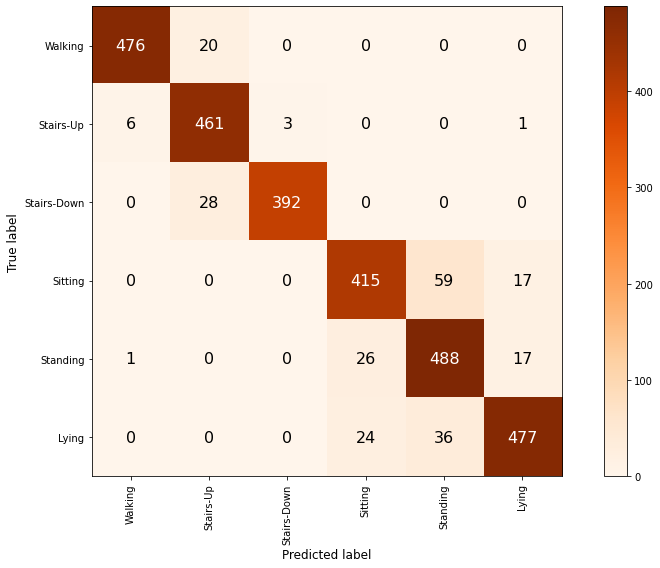

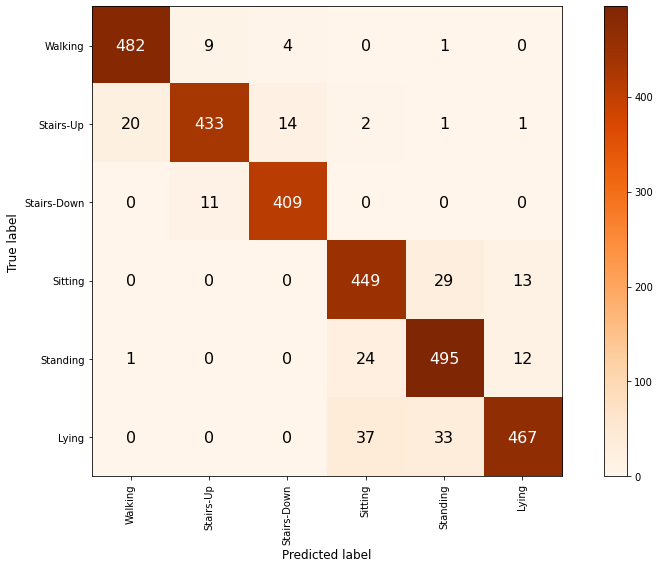

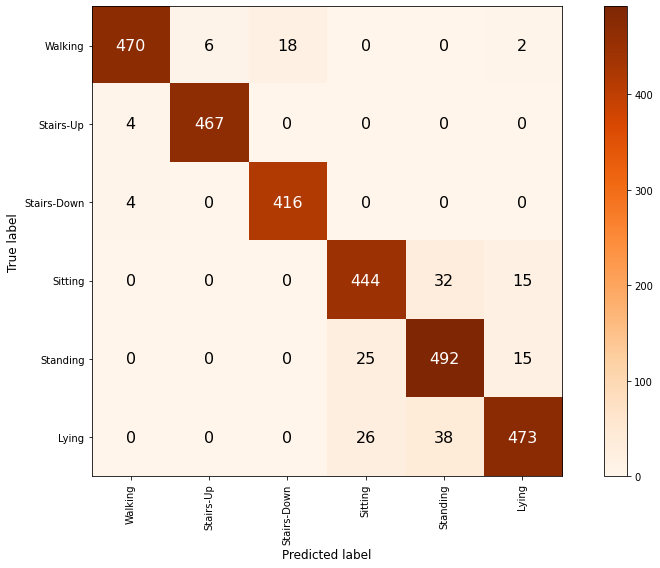

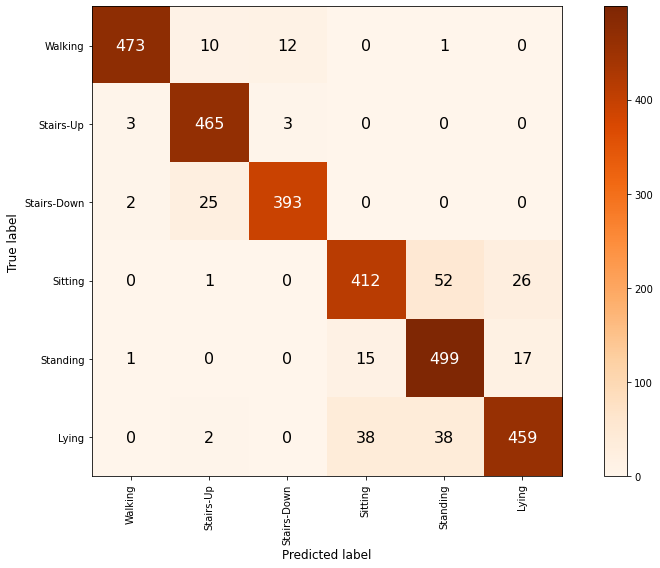

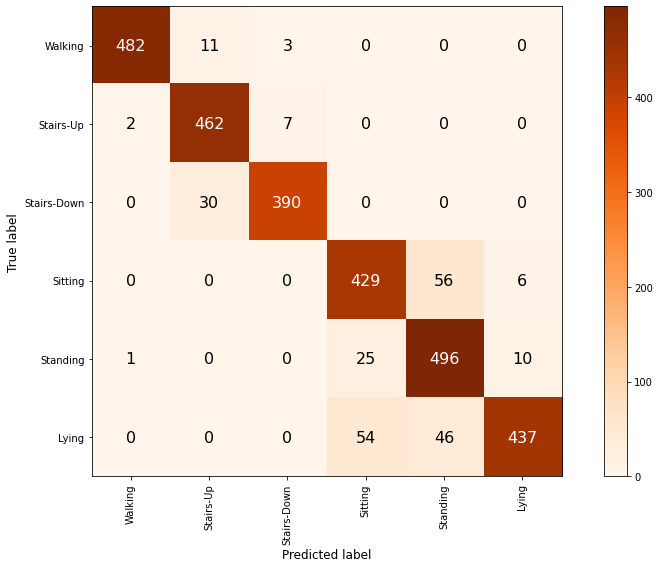

In [ ]:
seed_list=[1234,42,500,2000,100]
tf.random.set_seed(100)
flag_b=0
model = ConvLSTMCombined((w, h, 1), len(np.unique(Y_train)))
  #model.summary()
#X_train_Aug= resampling_fast_random(X_train) 
model,val_acc,loss = Model_Train(model, X_train[len(X_train)//10:], Y_train[len(X_train)//10:],
                              X_train[:len(X_train)//10], Y_train[:len(X_train)//10],
                              data_class_weights,
                              batch_size=64, num_epochs=num_epochs,
                              save_dir = "saved_models/ConvLSTMCombined/model_" + str(num_epochs))
model.save_weights('/content/final_weights_'+str(100))
model.save('/content/model_seed_'+str(100))
Test_Model(model)
flag_b=1
for se in seed_list:
  tf.random.set_seed(se)
  model = ConvLSTMCombined((w, h, 1), len(np.unique(Y_train)))
  #model.summary()
  #X_train_Aug= resampling(X_train,1,0) 
  X_train_Aug=X_train
  model,val_acc,loss = Model_Train(model, X_train_Aug[len(X_train_Aug)//10:], Y_train[len(X_train_Aug)//10:],
                              X_train_Aug[:len(X_train_Aug)//10], Y_train[:len(X_train_Aug)//10],
                              data_class_weights,
                              batch_size=64, num_epochs=num_epochs,
                              save_dir = "saved_models/ConvLSTMCombined/model_" + str(num_epochs))
  model.save_weights('/content/final_weights_'+str(se))
  model.save("'/content/model_seed_'+str(se)")
  Test_Model(model)


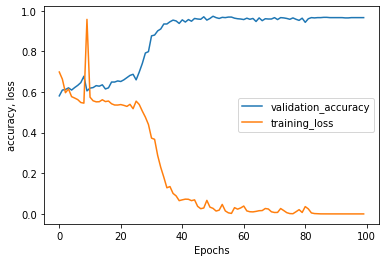

In [ ]:
plot_graphs(val_acc,loss)

### Test Accuracy for standard Model

In [ ]:
## Testing
test_accuracy = tf.keras.metrics.Accuracy()
logits = model(X_test, training=False)
prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
test_accuracy(prediction, Y_test)
print("Test Accuracy {:.4f}".format(test_accuracy.result()))

Test Accuracy 0.9111


In [ ]:
cr = classification_report(Y_test, prediction)
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       496
           1       0.92      0.99      0.95       471
           2       0.99      0.94      0.97       420
           3       0.85      0.85      0.85       491
           4       0.84      0.90      0.87       532
           5       0.91      0.85      0.88       537

    accuracy                           0.91      2947
   macro avg       0.92      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



In [ ]:
plot_classification_report(cr)
plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
plt.close()

[0.99, 0.94, 0.96]
[0.92, 0.99, 0.95]
[0.99, 0.94, 0.97]
[0.85, 0.85, 0.85]
[0.84, 0.9, 0.87]
[0.91, 0.85, 0.88]
plotMat: [[0.99, 0.94, 0.96], [0.92, 0.99, 0.95], [0.99, 0.94, 0.97], [0.85, 0.85, 0.85], [0.84, 0.9, 0.87], [0.91, 0.85, 0.88]]
support: [496, 471, 420, 491, 532, 537]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.


In [ ]:
lbls = ["Walking", "Stairs-Up", "Stairs-Down", "Sitting", "Standing", "Lying"]
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(figsize = (12,8))
    ax.grid(False)
    im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Oranges)
    ax.figure.colorbar(im, ax = ax)
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_ylabel('True label', fontsize=12)
    ax.set_xticklabels([''] + lbls)
    ax.set_yticklabels([''] + lbls)
    plt.xticks(rotation=90)
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i,j]), ha = "center", va = "center", color = "white" if cm[i,j]> thresh else "black", fontsize=16)
            fig.tight_layout()

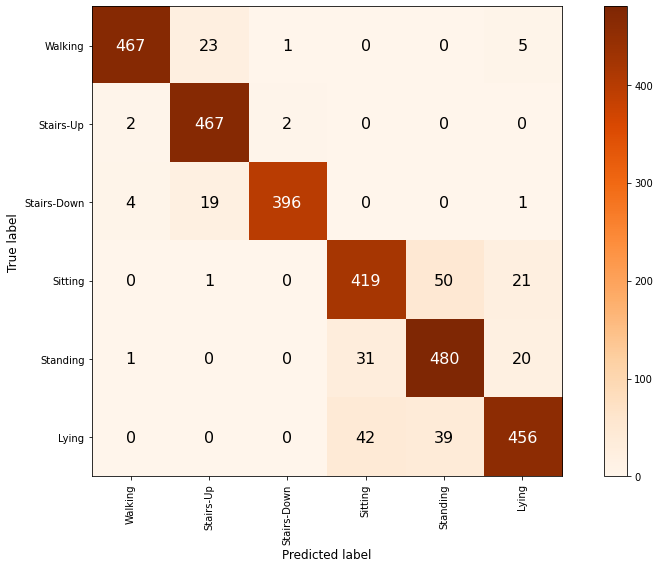

In [ ]:
# Plot confusion Matrix
cm = confusion_matrix(Y_test, prediction)
plot_confusion_matrix(cm)

In [ ]:
#class wise accuracy
cm.diagonal()/cm.sum(axis=1)

array([0.94153226, 0.99150743, 0.94285714, 0.85336049, 0.90225564,
       0.84916201])